# Introduction

The following notebook it aimed at quantifying the movement of CDR domains in TCR variable regions between unbound (*apo*) and bound (*holo*) conformations. The *holo* conforomations in this case are TCRs bound to class I pMHC complexes.

In [3]:
import glob
import os
import itertools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns

from python_pdb.comparisons import rmsd
from python_pdb.entities import Structure
from python_pdb.parsers import parse_pdb

from python_pdb.formats.residue import THREE_TO_ONE_CODE
from tcr_structure_tools.cdr_numbering import IMGT_CDR1, IMGT_CDR2, IMGT_CDR3, IMGT_CDR, assign_cdr_number

In [4]:
DATA_DIR = '/project/koohylab/bmcmaste/projects/tcr-pmhc-interface-analysis/data/apo-holo-mhc-class-I_refined_aligned'

In [5]:
print(DATA_DIR)

/project/koohylab/bmcmaste/projects/tcr-pmhc-interface-analysis/data/apo-holo-mhc-class-I_refined_aligned


## Calculating RMSD between conformations

Now that the structures have been align, RMSD can be computed between all states of the same TCR. Comparions between the different *apo* and *holo* forms are also done so that these can be used as a control for the differences in *apo* to *holo* comparisons.

In [6]:
def get_chain_assignments(file_path):
    chains = file_path.split('/')[-1].split('_')[1]
    
    return {chain: annotation 
            for chain, annotation in zip(chains, ['alpha_chain', 'beta_chain', 'antigen_chain', 'mhc_chain1', 'mhc_chain2'][:len(chains)])}

def get_coords(df):
    return df[['pos_x', 'pos_y', 'pos_z']].to_numpy()

groups = []
struct1s = []
struct2s = []
cdrs = []
chain_types = []
rmsds = []

for group in os.listdir(DATA_DIR):
    if not os.path.isdir(os.path.join(DATA_DIR, group)):
        continue
        
    pdb_files = [file for file in os.listdir(os.path.join(DATA_DIR, group)) if file.endswith('.pdb')]
    
    for path1, path2 in itertools.combinations(pdb_files, 2):
        print(path1, path2)
        chains1 = get_chain_assignments(path1)
        chains2 = get_chain_assignments(path2)
        
        with open(os.path.join(DATA_DIR, group, path1), 'r') as fh:
            structure1_df = parse_pdb(fh.read(), silent=True).to_pandas()
        
        with open(os.path.join(DATA_DIR, group, path2), 'r') as fh:
            structure2_df = parse_pdb(fh.read(), silent=True).to_pandas()
        
        structure1_df['chain_type'] = structure1_df['chain_id'].map(lambda chain_id: chains1[chain_id])
        structure2_df['chain_type'] = structure2_df['chain_id'].map(lambda chain_id: chains2[chain_id])
        
        structure1_df['cdr'] = structure1_df['residue_seq_id'].map(assign_cdr_number)
        structure2_df['cdr'] = structure2_df['residue_seq_id'].map(assign_cdr_number)
        
        structure1_df['backbone'] = structure1_df['atom_name'].map(lambda atom_name: (atom_name == 'N' or atom_name == 'CA' or atom_name == 'C' or atom_name == 'O'))
        structure2_df['backbone'] = structure2_df['atom_name'].map(lambda atom_name: (atom_name == 'N' or atom_name == 'CA' or atom_name == 'C' or atom_name == 'O'))
        
        struct_1_cdr_1_alpha_backbone = structure1_df.query("cdr == 1 and chain_type == 'alpha_chain' and backbone")
        struct_1_cdr_2_alpha_backbone = structure1_df.query("cdr == 2 and chain_type == 'alpha_chain' and backbone")
        struct_1_cdr_3_alpha_backbone = structure1_df.query("cdr == 3 and chain_type == 'alpha_chain' and backbone")
        
        struct_1_cdr_1_beta_backbone = structure1_df.query("cdr == 1 and chain_type == 'beta_chain' and backbone")
        struct_1_cdr_2_beta_backbone = structure1_df.query("cdr == 2 and chain_type == 'beta_chain' and backbone")
        struct_1_cdr_3_beta_backbone = structure1_df.query("cdr == 3 and chain_type == 'beta_chain' and backbone")
        
        struct_2_cdr_1_alpha_backbone = structure2_df.query("cdr == 1 and chain_type == 'alpha_chain' and backbone")
        struct_2_cdr_2_alpha_backbone = structure2_df.query("cdr == 2 and chain_type == 'alpha_chain' and backbone")
        struct_2_cdr_3_alpha_backbone = structure2_df.query("cdr == 3 and chain_type == 'alpha_chain' and backbone")
        
        struct_2_cdr_1_beta_backbone = structure2_df.query("cdr == 1 and chain_type == 'beta_chain' and backbone")
        struct_2_cdr_2_beta_backbone = structure2_df.query("cdr == 2 and chain_type == 'beta_chain' and backbone")
        struct_2_cdr_3_beta_backbone = structure2_df.query("cdr == 3 and chain_type == 'beta_chain' and backbone")
        
        for _ in range(6):
            groups.append(group)
            struct1s.append(path1)
            struct2s.append(path2)
        
        for _ in range(3):
            chain_types.append('alpha')
        
        cdrs.append('CDR1')
        rmsds.append(rmsd(get_coords(struct_1_cdr_1_alpha_backbone), get_coords(struct_2_cdr_1_alpha_backbone)))
        cdrs.append('CDR2')
        rmsds.append(rmsd(get_coords(struct_1_cdr_2_alpha_backbone), get_coords(struct_2_cdr_2_alpha_backbone)))
        cdrs.append('CDR3')
        rmsds.append(rmsd(get_coords(struct_1_cdr_3_alpha_backbone), get_coords(struct_2_cdr_3_alpha_backbone)))
        
        for _ in range(3):
            chain_types.append('beta')
        
        cdrs.append('CDR1')
        rmsds.append(rmsd(get_coords(struct_1_cdr_1_beta_backbone), get_coords(struct_2_cdr_1_beta_backbone)))
        cdrs.append('CDR2')
        rmsds.append(rmsd(get_coords(struct_1_cdr_2_beta_backbone), get_coords(struct_2_cdr_2_beta_backbone)))
        cdrs.append('CDR3')
        rmsds.append(rmsd(get_coords(struct_1_cdr_3_beta_backbone), get_coords(struct_2_cdr_3_beta_backbone)))

7n1c_DE_apo.pdb 7n1e_DECA_holo.pdb
6at6_AB_apo.pdb 6avf_ABPH_holo.pdb
3vxt_AB_apo.pdb 3vxu_DECA_holo.pdb
3vxt_AB_apo.pdb 3w0w_DECA_holo.pdb
3vxu_DECA_holo.pdb 3w0w_DECA_holo.pdb
6vth_DE_apo.pdb 6vrm_DEPA_holo.pdb
1g6r_ABPH_holo.pdb 2ckb_CDQI_holo.pdb
1g6r_ABPH_holo.pdb 1mwa_ABPH_holo.pdb
1g6r_ABPH_holo.pdb 2oi9_BCQA_holo.pdb
1g6r_ABPH_holo.pdb 1tcr_AB_apo.pdb
2ckb_CDQI_holo.pdb 1mwa_ABPH_holo.pdb
2ckb_CDQI_holo.pdb 2oi9_BCQA_holo.pdb
2ckb_CDQI_holo.pdb 1tcr_AB_apo.pdb
1mwa_ABPH_holo.pdb 2oi9_BCQA_holo.pdb
1mwa_ABPH_holo.pdb 1tcr_AB_apo.pdb
2oi9_BCQA_holo.pdb 1tcr_AB_apo.pdb
5nmf_DECA_holo.pdb 5nmd_AB_apo.pdb
5nmf_DECA_holo.pdb 5nmg_DECA_holo.pdb
5nmf_DECA_holo.pdb 5nme_IJHF_holo.pdb
5nmd_AB_apo.pdb 5nmg_DECA_holo.pdb
5nmd_AB_apo.pdb 5nme_IJHF_holo.pdb
5nmg_DECA_holo.pdb 5nme_IJHF_holo.pdb
7n1f_DECA_holo.pdb 7rtr_DECA_holo.pdb
7n1f_DECA_holo.pdb 7n1d_AB_apo.pdb
7rtr_DECA_holo.pdb 7n1d_AB_apo.pdb
4jff_DECA_holo.pdb 4jfe_DECA_holo.pdb
4jff_DECA_holo.pdb 6eqb_DECA_holo.pdb
4jff_DECA_holo.p

In [7]:
results = pd.DataFrame(zip(groups, struct1s, struct2s, chain_types, cdrs, rmsds), columns=['group', 'struct1', 'struct2', 'chain_type', 'cdr', 'rmsd'])
results

,group,struct1,struct2,chain_type,cdr,rmsd
0,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,7n1c_DE_apo.pdb,7n1e_DECA_holo.pdb,alpha,CDR1,2.460235
1,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,7n1c_DE_apo.pdb,7n1e_DECA_holo.pdb,alpha,CDR2,2.647571
2,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,7n1c_DE_apo.pdb,7n1e_DECA_holo.pdb,alpha,CDR3,1.955625
3,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,7n1c_DE_apo.pdb,7n1e_DECA_holo.pdb,beta,CDR1,0.656216
4,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,7n1c_DE_apo.pdb,7n1e_DECA_holo.pdb,beta,CDR2,0.791771
...,...,...,...,...,...,...
1027,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r7z_AB_apo.pdb,7r80_ABEC_holo.pdb,alpha,CDR2,0.843459
1028,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r7z_AB_apo.pdb,7r80_ABEC_holo.pdb,alpha,CDR3,0.855348
1029,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r7z_AB_apo.pdb,7r80_ABEC_holo.pdb,beta,CDR1,0.583384
1030,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r7z_AB_apo.pdb,7r80_ABEC_holo.pdb,beta,CDR2,0.315927


In [9]:
results['struct1_form'] = results['struct1'].map(lambda path: path.split('.')[0].split('_')[-1])
results['struct2_form'] = results['struct2'].map(lambda path: path.split('.')[0].split('_')[-1])
results['combined_structures'] = results.apply(lambda row: '-'.join(sorted([row['struct1'], row['struct2']])), axis=1)
results = results.drop_duplicates(['combined_structures', 'cdr', 'chain_type'])
results

,group,struct1,struct2,chain_type,cdr,rmsd,movement,struct1_form,struct2_form,combined_structures
0,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,7n1c_DE_apo.pdb,7n1e_DECA_holo.pdb,alpha,CDR1,2.460235,large movement,apo,holo,7n1c_DE_apo.pdb-7n1e_DECA_holo.pdb
1,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,7n1c_DE_apo.pdb,7n1e_DECA_holo.pdb,alpha,CDR2,2.647571,large movement,apo,holo,7n1c_DE_apo.pdb-7n1e_DECA_holo.pdb
2,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,7n1c_DE_apo.pdb,7n1e_DECA_holo.pdb,alpha,CDR3,1.955625,movement,apo,holo,7n1c_DE_apo.pdb-7n1e_DECA_holo.pdb
3,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,7n1c_DE_apo.pdb,7n1e_DECA_holo.pdb,beta,CDR1,0.656216,some movement,apo,holo,7n1c_DE_apo.pdb-7n1e_DECA_holo.pdb
4,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,7n1c_DE_apo.pdb,7n1e_DECA_holo.pdb,beta,CDR2,0.791771,some movement,apo,holo,7n1c_DE_apo.pdb-7n1e_DECA_holo.pdb
...,...,...,...,...,...,...,...,...,...,...
1027,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r7z_AB_apo.pdb,7r80_ABEC_holo.pdb,alpha,CDR2,0.843459,some movement,apo,holo,7r7z_AB_apo.pdb-7r80_ABEC_holo.pdb
1028,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r7z_AB_apo.pdb,7r80_ABEC_holo.pdb,alpha,CDR3,0.855348,some movement,apo,holo,7r7z_AB_apo.pdb-7r80_ABEC_holo.pdb
1029,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r7z_AB_apo.pdb,7r80_ABEC_holo.pdb,beta,CDR1,0.583384,some movement,apo,holo,7r7z_AB_apo.pdb-7r80_ABEC_holo.pdb
1030,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r7z_AB_apo.pdb,7r80_ABEC_holo.pdb,beta,CDR2,0.315927,little movement,apo,holo,7r7z_AB_apo.pdb-7r80_ABEC_holo.pdb


# Visualizing and analysing the results

## Measuring the distance between apo and holo confomations

Since RMSD was calculated for all pairings of the same TCR, the apo-holo (or holo-apo) comparisons were selected.

In [10]:
apo_holo = results.query('struct1_form != struct2_form').copy()
apo_holo

,group,struct1,struct2,chain_type,cdr,rmsd,movement,struct1_form,struct2_form,combined_structures
0,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,7n1c_DE_apo.pdb,7n1e_DECA_holo.pdb,alpha,CDR1,2.460235,large movement,apo,holo,7n1c_DE_apo.pdb-7n1e_DECA_holo.pdb
1,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,7n1c_DE_apo.pdb,7n1e_DECA_holo.pdb,alpha,CDR2,2.647571,large movement,apo,holo,7n1c_DE_apo.pdb-7n1e_DECA_holo.pdb
2,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,7n1c_DE_apo.pdb,7n1e_DECA_holo.pdb,alpha,CDR3,1.955625,movement,apo,holo,7n1c_DE_apo.pdb-7n1e_DECA_holo.pdb
3,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,7n1c_DE_apo.pdb,7n1e_DECA_holo.pdb,beta,CDR1,0.656216,some movement,apo,holo,7n1c_DE_apo.pdb-7n1e_DECA_holo.pdb
4,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,7n1c_DE_apo.pdb,7n1e_DECA_holo.pdb,beta,CDR2,0.791771,some movement,apo,holo,7n1c_DE_apo.pdb-7n1e_DECA_holo.pdb
...,...,...,...,...,...,...,...,...,...,...
1027,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r7z_AB_apo.pdb,7r80_ABEC_holo.pdb,alpha,CDR2,0.843459,some movement,apo,holo,7r7z_AB_apo.pdb-7r80_ABEC_holo.pdb
1028,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r7z_AB_apo.pdb,7r80_ABEC_holo.pdb,alpha,CDR3,0.855348,some movement,apo,holo,7r7z_AB_apo.pdb-7r80_ABEC_holo.pdb
1029,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r7z_AB_apo.pdb,7r80_ABEC_holo.pdb,beta,CDR1,0.583384,some movement,apo,holo,7r7z_AB_apo.pdb-7r80_ABEC_holo.pdb
1030,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r7z_AB_apo.pdb,7r80_ABEC_holo.pdb,beta,CDR2,0.315927,little movement,apo,holo,7r7z_AB_apo.pdb-7r80_ABEC_holo.pdb


In [14]:
apo_holo_norm = apo_holo.groupby(['group', 'chain_type', 'cdr'])['rmsd'].mean().reset_index()

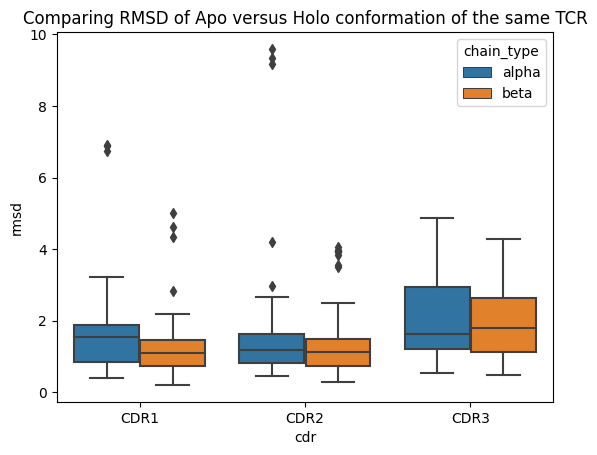

In [15]:
sns.boxplot(data=apo_holo, y='rmsd', x='cdr', hue='chain_type')
plt.title('Comparing RMSD of Apo versus Holo conformation of the same TCR')

apo_holo.groupby(['cdr', 'chain_type'])['rmsd'].describe()
# plt.savefig('figures/apo-holo.svg')

count      mean       std       min       25%       50%  \
cdr  chain_type                                                            
CDR1 alpha        18.0  1.697102  1.110940  0.561644  0.947288  1.605931   
     beta         18.0  1.091561  0.735940  0.400722  0.643893  0.987363   
CDR2 alpha        18.0  1.640305  1.512607  0.561268  0.891619  1.398928   
     beta         18.0  1.164234  0.949739  0.315239  0.555522  0.948982   
CDR3 alpha        18.0  2.382195  1.343027  0.540156  1.290291  1.867104   
     beta         18.0  1.731689  0.922992  0.477338  1.014221  1.524734   

                      75%       max  
cdr  chain_type                      
CDR1 alpha       1.987511  5.534306  
     beta        1.232472  3.670231  
CDR2 alpha       1.800321  7.286722  
     beta        1.284872  3.967234  
CDR3 alpha       3.694422  4.689000  
     beta        2.200752  3.345076

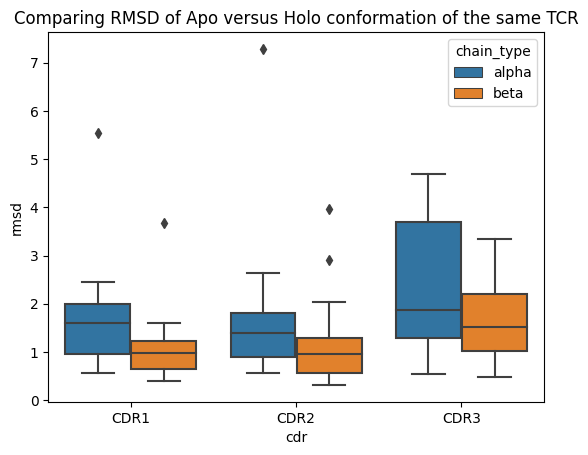

In [15]:
sns.boxplot(data=apo_holo_norm, y='rmsd', x='cdr', hue='chain_type')
plt.title('Comparing RMSD of Apo versus Holo conformation of the same TCR')

apo_holo_norm.groupby(['cdr', 'chain_type'])['rmsd'].describe()
# plt.savefig('figures/apo-holo_norm.svg')

The figure above shows there appears to be an increase in the movement of CDR3 compared to CDR1 and CDR2 and that the alpha chain has more movement than the beta chain of the TCR.

/package/python-cbrg/current/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/package/python-cbrg/current/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/package/python-cbrg/current/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/package/python-cbrg/current/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and

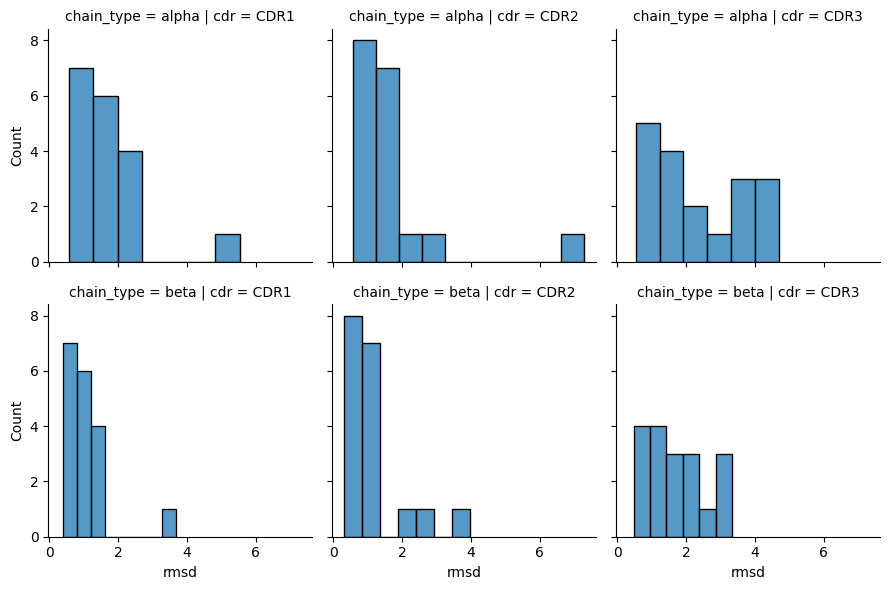

In [16]:
g = sns.FacetGrid(apo_holo_norm, row='chain_type', col='cdr')
g.map(sns.histplot, 'rmsd')

The RMSD distributions are somewhat left skewed and don't look particularily normal.

In [17]:
movement_order = pd.CategoricalDtype(categories=['little movement', 'some movement', 'movement', 'large movement', 'significant movement'], ordered=True)

def categorize_movement(rmsd: float) -> str:
    if rmsd < 0.5:
        return 'little movement'
    
    if 0.5 <= rmsd < 1.0:
        return 'some movement'
    
    if 1.0 <= rmsd < 2.0:
        return 'movement'
    
    if 2.0 <= rmsd < 4.0:
        return 'large movement'
    
    if 4.0 <= rmsd:
        return 'significant movement'

apo_holo_norm['movement'] = apo_holo_norm['rmsd'].map(categorize_movement).astype(movement_order)
apo_holo_norm

,group,chain_type,cdr,rmsd,movement
0,DRGSQS-IYSNGD-AVNFGGGKLI-MRHNA-SNTAGT-ASSLSFGTEAF,alpha,CDR1,2.097067,large movement
1,DRGSQS-IYSNGD-AVNFGGGKLI-MRHNA-SNTAGT-ASSLSFGTEAF,alpha,CDR2,1.400203,movement
2,DRGSQS-IYSNGD-AVNFGGGKLI-MRHNA-SNTAGT-ASSLSFGTEAF,alpha,CDR3,1.778582,movement
3,DRGSQS-IYSNGD-AVNFGGGKLI-MRHNA-SNTAGT-ASSLSFGTEAF,beta,CDR1,1.610282,movement
4,DRGSQS-IYSNGD-AVNFGGGKLI-MRHNA-SNTAGT-ASSLSFGTEAF,beta,CDR2,2.035251,large movement
...,...,...,...,...,...
103,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,alpha,CDR2,2.647571,large movement
104,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,alpha,CDR3,1.955625,movement
105,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,beta,CDR1,0.656216,some movement
106,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,beta,CDR2,0.791771,some movement


<Axes: ylabel='count'>

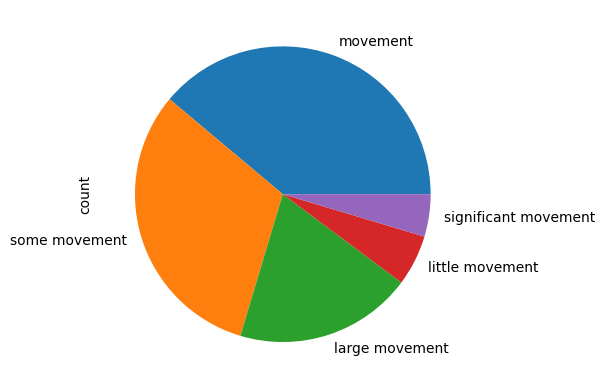

In [18]:
apo_holo_norm['movement'].value_counts().plot.pie()

## Comparison of *apo*-*apo* and *holo*-*holo* to *apo*-*holo* (or vice versa) structures

The following analysis aims to ascertain whether there is notable movement in the CDR domains between the *apo* and *holo* conformations, using *apo*-*apo* and *holo*-*holo* differences as controls.

In [33]:
results_norm

,group,comparison,cdr,chain_type,rmsd
0,DRGSQS-IYSNGD-AVNFGGGKLI-MRHNA-SNTAGT-ASSLSFGTEAF,apo-holo,CDR1,alpha,2.097067
1,DRGSQS-IYSNGD-AVNFGGGKLI-MRHNA-SNTAGT-ASSLSFGTEAF,apo-holo,CDR1,beta,1.610282
2,DRGSQS-IYSNGD-AVNFGGGKLI-MRHNA-SNTAGT-ASSLSFGTEAF,apo-holo,CDR2,alpha,1.400203
3,DRGSQS-IYSNGD-AVNFGGGKLI-MRHNA-SNTAGT-ASSLSFGTEAF,apo-holo,CDR2,beta,2.035251
4,DRGSQS-IYSNGD-AVNFGGGKLI-MRHNA-SNTAGT-ASSLSFGTEAF,apo-holo,CDR3,alpha,1.778582
...,...,...,...,...,...
175,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,apo-holo,CDR1,beta,0.656216
176,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,apo-holo,CDR2,alpha,2.647571
177,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,apo-holo,CDR2,beta,0.791771
178,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,apo-holo,CDR3,alpha,1.955625


/package/python-cbrg/current/3.11/lib/python3.11/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


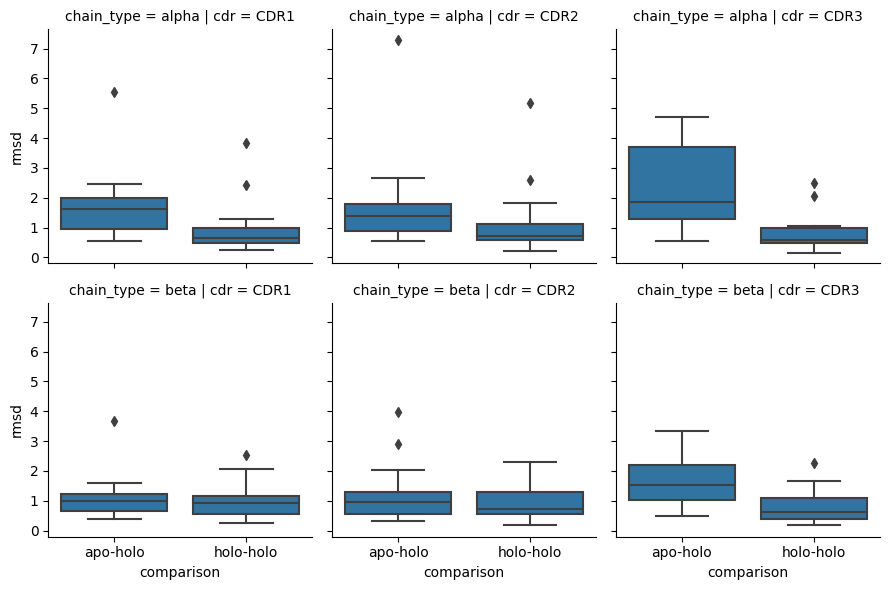

In [34]:
results['comparison'] = results['struct1_form'] + '-' + results['struct2_form']
results['comparison'] = results['comparison'].map(lambda entry: 'apo-holo' if entry == 'holo-apo' else entry)

results_norm = results.groupby(['group', 'comparison', 'cdr', 'chain_type'])['rmsd'].mean().reset_index()

g = sns.FacetGrid(results_norm.sort_values(['comparison', 'chain_type', 'cdr']), col='cdr', row='chain_type')
g.map(sns.boxplot, 'comparison', 'rmsd')
# plt.savefig('figures/movement-comparisons_norm.svg')

/package/python-cbrg/current/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/package/python-cbrg/current/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


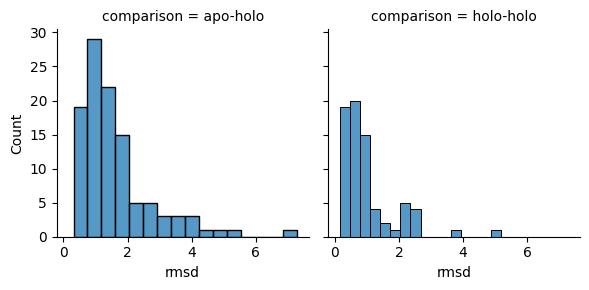

In [23]:
g = sns.FacetGrid(results_norm.sort_values('comparison'), col='comparison')
g.map(sns.histplot, 'rmsd')

In [35]:
treatment_options = ['comparison', 'chain_type', 'cdr']
treatments = [(group, df['rmsd'].to_numpy()) for group, df in results_norm.groupby(treatment_options)]
treatments
print(scipy.stats.kruskal(*[values for _, values in treatments]))

KruskalResult(statistic=40.30647636586855, pvalue=3.1704097798022664e-05)


In [36]:
combos = []
for pairing in list(itertools.combinations(treatments, 2)):
    chain_type_x = pairing[0][0][1]
    cdr_x = pairing[0][0][2]
    chain_type_y = pairing[1][0][1]
    cdr_y = pairing[1][0][2]
    
    if (chain_type_x, cdr_x) == (chain_type_y, cdr_y):
        combos.append(pairing)

significance_level = 0.05 / len(combos)
print(significance_level)
statistics = []
p_vals = []

for ((comparison_x, chain_type_x, cdr_x), sample_x), ((comparison_y, chain_type_y, cdr_y), sample_y) in combos:
    stat, p_val = scipy.stats.ranksums(sample_x, sample_y)
    
    statistics.append(stat)
    p_vals.append(p_val)

pd.DataFrame({
    'comparison_x': [name for ((name, _, _), _), _ in combos],
    'chain_type_x': [name for ((_, name, _), _), _ in combos],
    'cdr_x': [name for ((_, _, name), _), _ in combos],
    'comparison_y': [name for _, ((name, _, _), _) in combos],
    'chain_type_y': [name for _, ((_, name, _), _) in combos],
    'cdr_y': [name for _, ((_, _, name), _) in combos],
    'statistic': statistics,
    'p_val': p_vals,
    'significant': [p_val < significance_level for p_val in p_vals],
})

0.008333333333333333


,comparison_x,chain_type_x,cdr_x,comparison_y,chain_type_y,cdr_y,statistic,p_val,significant
0,apo-holo,alpha,CDR1,holo-holo,alpha,CDR1,2.497669,0.012501,False
1,apo-holo,alpha,CDR2,holo-holo,alpha,CDR2,1.947335,0.051495,False
2,apo-holo,alpha,CDR3,holo-holo,alpha,CDR3,3.344337,0.000825,True
3,apo-holo,beta,CDR1,holo-holo,beta,CDR1,0.423334,0.672052,False
4,apo-holo,beta,CDR2,holo-holo,beta,CDR2,0.423334,0.672052,False
5,apo-holo,beta,CDR3,holo-holo,beta,CDR3,2.709336,0.006742,True


In [32]:
combos = list(itertools.combinations(treatments, 2))

significance_level = 0.05 / len(combos)

statistics = []
p_vals = []

for ((comparison_x, chain_type_x, cdr_x), sample_x), ((comparison_y, chain_type_y, cdr_y), sample_y) in combos:
    stat, p_val = scipy.stats.ranksums(sample_x, sample_y)
    
    statistics.append(stat)
    p_vals.append(p_val)

pd.DataFrame({
    'comparison_x': [name for ((name, _, _), _), _ in combos],
    'chain_type_x': [name for ((_, name, _), _), _ in combos],
    'cdr_x': [name for ((_, _, name), _), _ in combos],
    'comparison_y': [name for _, ((name, _, _), _) in combos],
    'chain_type_y': [name for _, ((_, name, _), _) in combos],
    'cdr_y': [name for _, ((_, _, name), _) in combos],
    'statistic': statistics,
    'p_val': p_vals,
    'significant': [p_val < significance_level for p_val in p_vals],
})

,comparison_x,chain_type_x,cdr_x,comparison_y,chain_type_y,cdr_y,statistic,p_val,significant
0,apo-holo,alpha,CDR1,apo-holo,alpha,CDR2,0.664411,0.506428,False
1,apo-holo,alpha,CDR1,apo-holo,alpha,CDR3,-1.550291,0.121072,False
2,apo-holo,alpha,CDR1,apo-holo,beta,CDR1,2.404534,0.016193,False
3,apo-holo,alpha,CDR1,apo-holo,beta,CDR2,2.183063,0.029031,False
4,apo-holo,alpha,CDR1,apo-holo,beta,CDR3,-0.253109,0.800184,False
...,...,...,...,...,...,...,...,...,...
61,holo-holo,alpha,CDR3,holo-holo,beta,CDR2,-0.750555,0.452920,False
62,holo-holo,alpha,CDR3,holo-holo,beta,CDR3,0.000000,1.000000,False
63,holo-holo,beta,CDR1,holo-holo,beta,CDR2,0.404145,0.686106,False
64,holo-holo,beta,CDR1,holo-holo,beta,CDR3,0.692820,0.488422,False


The analysis of the plots and statistical tests shows that there is a statistically significant (p-value: 0.05) difference between the target and controls (as seen by the results of the Kruskal-Wallis test) but it also shows that there is a significant difference between the two controls.

# ⚠️ THE FOLLOWING SECTION IS NO LONGER NEEDED

The analysis above has been done in a more normalized way now.

## ... suspect that this is a popularity contest

That being said, based on the method in the first part of this analysis, more popular TCRs dominate the dataset and potentially cause some bias in results. Taking a look at the data, there are a few TCRs that have much higher abundance then others.

In [39]:
apo_holo['group'].value_counts()

group
NSAFQY-TYSSGN-AMRGDSSYKLI-SGHDY-FNNNVP-ASSLWEKLAKNIQY     54
DRGSQS-IYSNGD-AVTTDSWGKLQ-MNHEY-SVGAGI-ASRPGLAGGRPEQY     54
FLGSQS-TYREGD-AVNDGGRLT-GTSNPN-WGPFG-AWSETGLGMGGWQ        30
YSATPY-YYSGDPVV-AVSGFASALT-NNHNN-SYGAGS-ASGGGGTLY         24
SVFSS-VVTGGEV-AGAGSQGNLI-LNHDA-SQIVND-ASSSRSSYEQY         24
DRGSQS-IYSNGD-AVNFGGGKLI-MRHNA-SNTAGT-ASSLSFGTEAF         24
DSAIYN-IQSSQRE-AVRPTSGGSYIPT-MNHEY-SVGAGI-ASSYVGNTGELF    24
DRGSQS-IYSNGD-AVRTNSGYALN-QGHDT-YYEEEE-ASSDTVSYEQY        18
TISGTDY-GLTSN-ILPLAGGTSYGKLT-SGHVS-FQNEAQ-ASSLGQAYEQY     18
DRGSQS-IYSNGD-GTYNQGGKLI-MNHEY-SMNVEV-ASSGASHEQY          12
DRGSQS-IYSNGD-AVNRDDKII-SEHNR-FQNEAQ-ASSPDIEQY            12
DSAIYN-IQSSQRE-AVRMDSSYKLI-SEHNR-FQNEAQ-ASSSWDTGELF       12
DSAIYN-IQSSQRE-AVRPLLDGTYIPT-MNHEY-SVGAGT-ASSYLGNTGELF     6
NSAFDY-ILSVSNK-AASASFGDNSKLI-MSHET-SYDVDS-ASSLGHTEVF       6
YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGAGGADTQY      6
NIATNDY-GYKTK-LVGEILDNFNKFY-MDHEN-SYDVKM-ASSQRQEGDTQY      6
NSASQS-VYSSG-VVQPG

# Re-doing the calculations using average *apo* and *holo* comformation

To remove the effects of this bias, the following section used a different approach, taking the average position of the *apo* forms and comparing it to the average position of the *holo* forms. In this way, each TCR will have one corresponding RMSD measurement.

In [49]:
groups = []
cdrs = []
chain_types = []
rmsds = []

for group in os.listdir(DATA_DIR):
    apo_files = glob.glob(os.path.join(DATA_DIR, group, '*apo.pdb'))
    holo_files = glob.glob(os.path.join(DATA_DIR, group, '*holo.pdb'))

    num_apo_files = len(apo_files)
    num_holo_files = len(holo_files)
    
    apo_avg_cdr_1_alpha_coords = None
    apo_avg_cdr_2_alpha_coords = None
    apo_avg_cdr_3_alpha_coords = None
    apo_avg_cdr_1_beta_coords = None
    apo_avg_cdr_2_beta_coords = None
    apo_avg_cdr_3_beta_coords = None
    
    for path in apo_files:
        chains = get_chain_assignments(path)
        
        with open(path, 'r') as fh:
            structure_df = parse_pdb(fh.read(), silent=True).to_pandas()
            
        structure_df['chain_type'] = structure_df['chain_id'].map(lambda chain_id: chains[chain_id])
        structure_df['cdr'] = structure_df['residue_seq_id'].map(assign_cdr_number)
        structure_df['backbone'] = structure_df['atom_name'].map(lambda atom_name: (atom_name == 'N' or atom_name == 'CA' or atom_name == 'C' or atom_name == 'O'))

        struct_cdr_1_alpha_backbone = get_coords(structure_df.query("cdr == 1 and chain_type == 'alpha_chain' and backbone"))
        struct_cdr_2_alpha_backbone = get_coords(structure_df.query("cdr == 2 and chain_type == 'alpha_chain' and backbone"))
        struct_cdr_3_alpha_backbone = get_coords(structure_df.query("cdr == 3 and chain_type == 'alpha_chain' and backbone"))

        struct_cdr_1_beta_backbone = get_coords(structure_df.query("cdr == 1 and chain_type == 'beta_chain' and backbone"))
        struct_cdr_2_beta_backbone = get_coords(structure_df.query("cdr == 2 and chain_type == 'beta_chain' and backbone"))
        struct_cdr_3_beta_backbone = get_coords(structure_df.query("cdr == 3 and chain_type == 'beta_chain' and backbone"))

        apo_avg_cdr_1_alpha_coords = struct_cdr_1_alpha_backbone if apo_avg_cdr_1_alpha_coords is None else apo_avg_cdr_1_alpha_coords + struct_cdr_1_alpha_backbone
        apo_avg_cdr_2_alpha_coords = struct_cdr_2_alpha_backbone if apo_avg_cdr_2_alpha_coords is None else apo_avg_cdr_2_alpha_coords + struct_cdr_2_alpha_backbone
        apo_avg_cdr_3_alpha_coords = struct_cdr_3_alpha_backbone if apo_avg_cdr_3_alpha_coords is None else apo_avg_cdr_3_alpha_coords + struct_cdr_3_alpha_backbone
        apo_avg_cdr_1_beta_coords = struct_cdr_1_beta_backbone if apo_avg_cdr_1_beta_coords is None else apo_avg_cdr_1_beta_coords + struct_cdr_1_beta_backbone
        apo_avg_cdr_2_beta_coords = struct_cdr_2_beta_backbone if apo_avg_cdr_2_beta_coords is None else apo_avg_cdr_2_beta_coords + struct_cdr_2_beta_backbone
        apo_avg_cdr_3_beta_coords = struct_cdr_3_beta_backbone if apo_avg_cdr_3_beta_coords is None else apo_avg_cdr_3_beta_coords + struct_cdr_3_beta_backbone
    
    apo_avg_cdr_1_alpha_coords /= num_apo_files
    apo_avg_cdr_2_alpha_coords /= num_apo_files
    apo_avg_cdr_3_alpha_coords /= num_apo_files
    apo_avg_cdr_1_beta_coords /= num_apo_files
    apo_avg_cdr_2_beta_coords /= num_apo_files
    apo_avg_cdr_3_beta_coords /= num_apo_files

    holo_avg_cdr_1_alpha_coords = None
    holo_avg_cdr_2_alpha_coords = None
    holo_avg_cdr_3_alpha_coords = None
    holo_avg_cdr_1_beta_coords = None
    holo_avg_cdr_2_beta_coords = None
    holo_avg_cdr_3_beta_coords = None
    
    for path in holo_files:
        chains = get_chain_assignments(path)
        
        with open(path, 'r') as fh:
            structure_df = parse_pdb(fh.read(), silent=True).to_pandas()
            
        structure_df['chain_type'] = structure_df['chain_id'].map(lambda chain_id: chains[chain_id])
        structure_df['cdr'] = structure_df['residue_seq_id'].map(assign_cdr_number)
        structure_df['backbone'] = structure_df['atom_name'].map(lambda atom_name: (atom_name == 'N' or atom_name == 'CA' or atom_name == 'C' or atom_name == 'O'))

        struct_cdr_1_alpha_backbone = get_coords(structure_df.query("cdr == 1 and chain_type == 'alpha_chain' and backbone"))
        struct_cdr_2_alpha_backbone = get_coords(structure_df.query("cdr == 2 and chain_type == 'alpha_chain' and backbone"))
        struct_cdr_3_alpha_backbone = get_coords(structure_df.query("cdr == 3 and chain_type == 'alpha_chain' and backbone"))

        struct_cdr_1_beta_backbone = get_coords(structure_df.query("cdr == 1 and chain_type == 'beta_chain' and backbone"))
        struct_cdr_2_beta_backbone = get_coords(structure_df.query("cdr == 2 and chain_type == 'beta_chain' and backbone"))
        struct_cdr_3_beta_backbone = get_coords(structure_df.query("cdr == 3 and chain_type == 'beta_chain' and backbone"))

        holo_avg_cdr_1_alpha_coords = struct_cdr_1_alpha_backbone if holo_avg_cdr_1_alpha_coords is None else holo_avg_cdr_1_alpha_coords + struct_cdr_1_alpha_backbone
        holo_avg_cdr_2_alpha_coords = struct_cdr_2_alpha_backbone if holo_avg_cdr_2_alpha_coords is None else holo_avg_cdr_2_alpha_coords + struct_cdr_2_alpha_backbone
        holo_avg_cdr_3_alpha_coords = struct_cdr_3_alpha_backbone if holo_avg_cdr_3_alpha_coords is None else holo_avg_cdr_3_alpha_coords + struct_cdr_3_alpha_backbone
        holo_avg_cdr_1_beta_coords = struct_cdr_1_beta_backbone if holo_avg_cdr_1_beta_coords is None else holo_avg_cdr_1_beta_coords + struct_cdr_1_beta_backbone
        holo_avg_cdr_2_beta_coords = struct_cdr_2_beta_backbone if holo_avg_cdr_2_beta_coords is None else holo_avg_cdr_2_beta_coords + struct_cdr_2_beta_backbone
        holo_avg_cdr_3_beta_coords = struct_cdr_3_beta_backbone if holo_avg_cdr_3_beta_coords is None else holo_avg_cdr_3_beta_coords + struct_cdr_3_beta_backbone
    
    holo_avg_cdr_1_alpha_coords /= num_holo_files
    holo_avg_cdr_2_alpha_coords /= num_holo_files
    holo_avg_cdr_3_alpha_coords /= num_holo_files
    holo_avg_cdr_1_beta_coords /= num_holo_files
    holo_avg_cdr_2_beta_coords /= num_holo_files
    holo_avg_cdr_3_beta_coords /= num_holo_files
    
    for _ in range(6):
        groups.append(group)

    for _ in range(3):
        chain_types.append('alpha')

    cdrs.append('CDR1')
    rmsds.append(rmsd(apo_avg_cdr_1_alpha_coords, holo_avg_cdr_1_alpha_coords))
    cdrs.append('CDR2')
    rmsds.append(rmsd(apo_avg_cdr_2_alpha_coords, holo_avg_cdr_2_alpha_coords))
    cdrs.append('CDR3')
    rmsds.append(rmsd(apo_avg_cdr_3_alpha_coords, holo_avg_cdr_3_alpha_coords))

    for _ in range(3):
        chain_types.append('beta')

    cdrs.append('CDR1')
    rmsds.append(rmsd(apo_avg_cdr_1_beta_coords, holo_avg_cdr_1_beta_coords))
    cdrs.append('CDR2')
    rmsds.append(rmsd(apo_avg_cdr_2_beta_coords, holo_avg_cdr_2_beta_coords))
    cdrs.append('CDR3')
    rmsds.append(rmsd(apo_avg_cdr_3_beta_coords, holo_avg_cdr_3_beta_coords))

In [50]:
results_avg = pd.DataFrame(zip(groups, chain_types, cdrs, rmsds), columns=['group', 'chain_type', 'cdr', 'rmsd'])
results_avg

,group,chain_type,cdr,rmsd
0,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,alpha,CDR1,2.460235
1,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,alpha,CDR2,2.647571
2,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,alpha,CDR3,1.955625
3,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,beta,CDR1,0.656216
4,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,beta,CDR2,0.791771
...,...,...,...,...
103,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,alpha,CDR2,0.843459
104,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,alpha,CDR3,0.855348
105,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,beta,CDR1,0.583384
106,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,beta,CDR2,0.315927


<Axes: ylabel='count'>

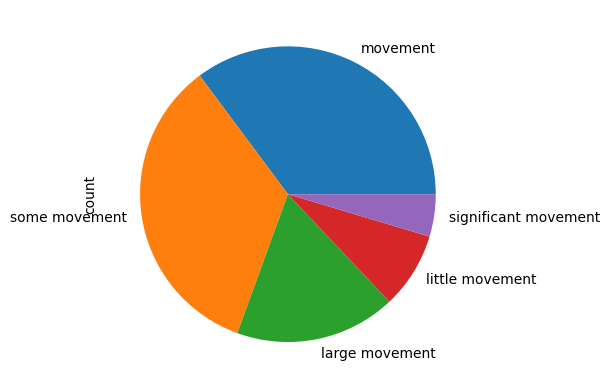

In [51]:
results_avg['movement'] = results_avg['rmsd'].map(categorize_movement)

results_avg['movement'].value_counts().plot.pie()

count      mean       std       min       25%       50%   
cdr  chain_type                                                            
CDR1 alpha        18.0  1.647040  1.048681  0.561644  0.902439  1.580671  \
     beta         18.0  1.008579  0.714516  0.400722  0.601592  0.904180   
CDR2 alpha        18.0  1.568069  1.445268  0.529454  0.815092  1.376687   
     beta         18.0  1.085898  0.928127  0.315239  0.527736  0.882240   
CDR3 alpha        18.0  2.327635  1.332878  0.534766  1.238051  1.853477   
     beta         18.0  1.669658  0.921113  0.469395  0.952088  1.418829   

                      75%       max  
cdr  chain_type                      
CDR1 alpha       1.964275  5.181593  
     beta        1.121543  3.597847  
CDR2 alpha       1.579754  6.947782  
     beta        1.145777  3.965313  
CDR3 alpha       3.646040  4.689000  
     beta        2.191157  3.345076

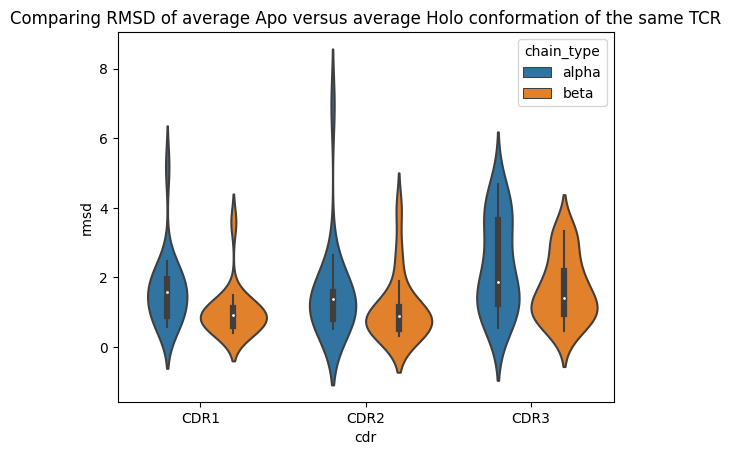

In [54]:
sns.violinplot(data=results_avg, y='rmsd', x='cdr', hue='chain_type')
plt.title('Comparing RMSD of average Apo versus average Holo conformation of the same TCR')

results_avg.groupby(['cdr', 'chain_type'])['rmsd'].describe()

The plots seem to show the same trend as before which is reassuring.

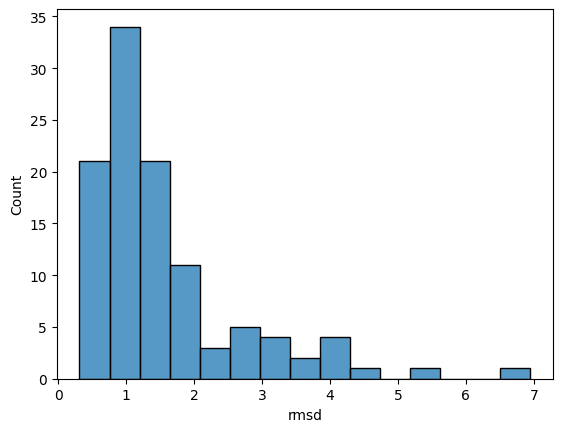

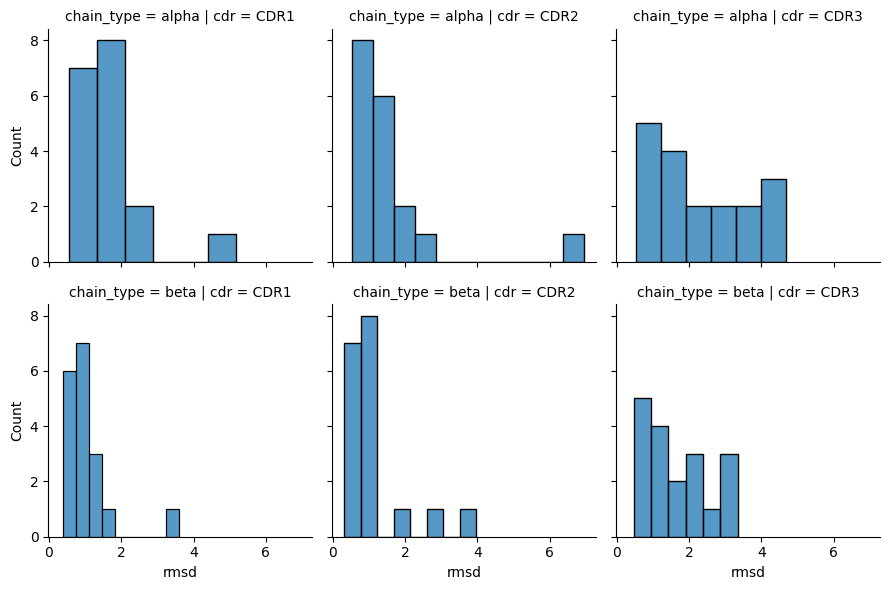

In [55]:
sns.histplot(results_avg, x='rmsd')

g = sns.FacetGrid(results_avg, row='chain_type', col='cdr')
g.map(sns.histplot, 'rmsd')

In [56]:
factors = list(itertools.product(('alpha', 'beta'), ('CDR1', 'CDR2', 'CDR3')))
samples = []
for chain, cdr in factors:
    samples.append(results_avg.query('chain_type == @chain and cdr == @cdr')['rmsd'].to_numpy())

print(scipy.stats.kruskal(*samples))    

print('\n\nPost hoc analysis')
combos = list(itertools.combinations(factors, 2))
significance_level = 0.05 / len(combos)

p_values = []
statistics = []

for (chain_x, cdr_x), (chain_y, cdr_y) in combos:
    sample_x = results_avg.query('chain_type == @chain_x and cdr == @cdr_x')
    sample_x = sample_x.sort_values('group')
    
    sample_y = results_avg.query('chain_type == @chain_y and cdr == @cdr_y')
    sample_y = sample_y.sort_values('group')
    
    statistic, p_value = scipy.stats.wilcoxon(sample_x['rmsd'].to_numpy(), sample_y['rmsd'].to_numpy())
    
    statistics.append(statistic)
    p_values.append(p_value)

results_avg_stats = pd.DataFrame({
    'sample 1': [f"{cdr}{chain}" for (chain, cdr), _ in combos],
    'sample 2': [f"{cdr}{chain}" for _, (chain, cdr) in combos],
    'statistics': statistics,
    'p_val': p_values,
})
results_avg_stats['significant'] = results_avg_stats['p_val'].map(lambda p_val: p_val < significance_level)

results_avg_stats

KruskalResult(statistic=21.80824555442291, pvalue=0.0005694151457078133)


Post hoc analysis


,sample 1,sample 2,statistics,p_val,significant
0,CDR1alpha,CDR2alpha,64.0,0.369217,False
1,CDR1alpha,CDR3alpha,46.0,0.089767,False
2,CDR1alpha,CDR1beta,23.0,0.004745,False
3,CDR1alpha,CDR2beta,26.0,0.007690,False
4,CDR1alpha,CDR3beta,81.0,0.865044,False
5,CDR2alpha,CDR3alpha,42.0,0.059937,False
6,CDR2alpha,CDR1beta,32.0,0.018234,False
7,CDR2alpha,CDR2beta,35.0,0.026848,False
8,CDR2alpha,CDR3beta,76.0,0.701881,False
9,CDR3alpha,CDR1beta,9.0,0.000252,True


The statistical tests show that there is some significant differences in these results.